In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
import numpy as np
from sklearn.cluster import KMeans

In [26]:
import warnings
warnings.filterwarnings('ignore')

# ***3.1 Explore the data***

## **3.1.1 Load data from my own google driver**
You can visit the code, output and the original data from:https://drive.google.com/drive/folders/18vlAyyRiEKBq9TJ0_HrASgO9WoXN_NJo?usp=sharing

The basic information of the dataset shown as follow 

In [27]:
# Read the dataset
data = pd.read_csv('F:/UZH/semester2/spatial_analysis2/assignment1/dc-isc-lu-data.csv')
print('check the colum the dataset has',data.columns)

check the colum the dataset has Index(['id', 'parcel_name', 'label', 'tw_0', 'tw_1', 'tw_2', 'tw_3', 'tw_4',
       'tw_5', 'tw_6',
       ...
       'entropy_158', 'entropy_159', 'entropy_160', 'entropy_161',
       'entropy_162', 'entropy_163', 'entropy_164', 'entropy_165',
       'entropy_166', 'entropy_167'],
      dtype='object', length=507)


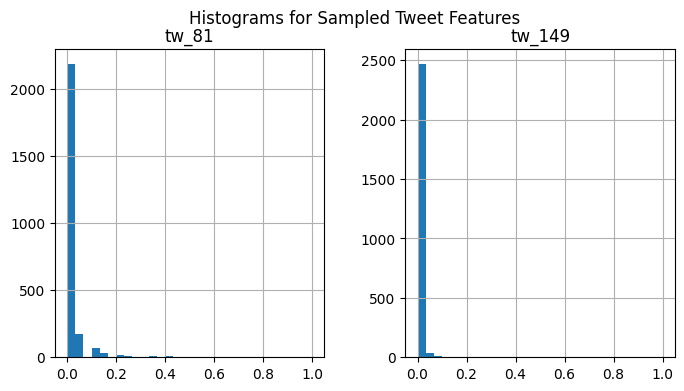

             tw_81       tw_149
count  2520.000000  2520.000000
mean      0.021607     0.002475
std       0.164616     0.035018
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       0.000000     0.000000
max       6.100000     1.190476


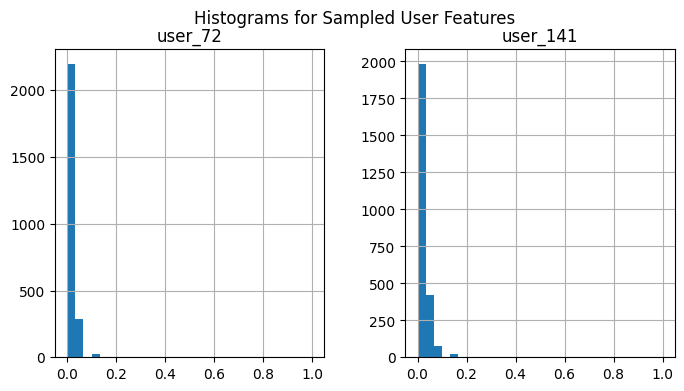

           user_72     user_141
count  2520.000000  2520.000000
mean      0.007619     0.014607
std       0.025153     0.041767
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       0.000000     0.000000
max       0.700000     0.857143


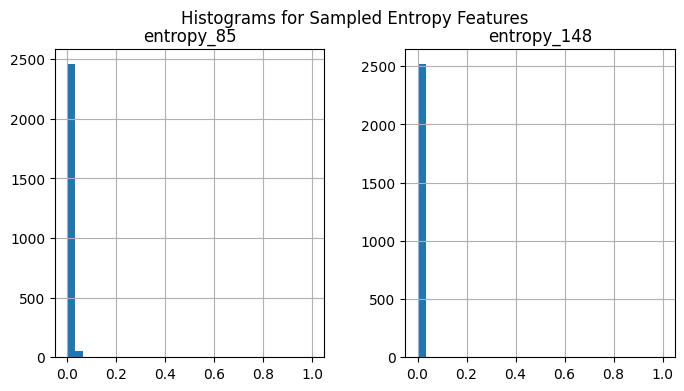

        entropy_85  entropy_148
count  2520.000000  2520.000000
mean      0.001359     0.000084
std       0.008220     0.001762
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       0.000000     0.000000
max       0.122358     0.052315


In [28]:
# Define a function to summarize and plot a group of features
def summarize_plot_features(feature_group, group_name):
    # Sample 2 features from the group for plotting
    sampled_features = feature_group.sample(2, axis=1)
    # Summarize the features
    summary = sampled_features.describe()
    # Plot histograms for the sampled features with x-axis range set to 0-1
    sampled_features.hist(bins=30, range=(0, 1), figsize=(8, 4))
    plt.suptitle(f'Histograms for Sampled {group_name} Features')
    plt.show()
    return summary


# Group features by type
tweet_features = data.filter(regex='^tw_')
user_features = data.filter(regex='^user_')
entropy_features = data.filter(regex='^entropy_')

# Summarize and plot tweet features
tweet_summary = summarize_plot_features(tweet_features, 'Tweet')
print(tweet_summary)
# Summarize and plot user features
user_summary = summarize_plot_features(user_features, 'User')
print(user_summary)
# Summarize and plot entropy features
entropy_summary = summarize_plot_features(entropy_features, 'Entropy')
print(entropy_summary)

The histograms and summary statistics for the sampled Twitter data features reveal a pattern of sparsity, with the majority of values concentrated at or near zero, indicating periods of low activity. Standard deviations are relatively high relative to the means, suggesting occasional bursts of high activity, which are also reflected in the presence of significant outliers. This is a common characteristic in social media data, where user activity can be infrequent but occasionally spike, making it challenging for distance-based clustering algorithms that may be influenced by the sparse nature of the data and the impact of outliers.

## **3.1.2 Residential and Non-Residential Comparison**

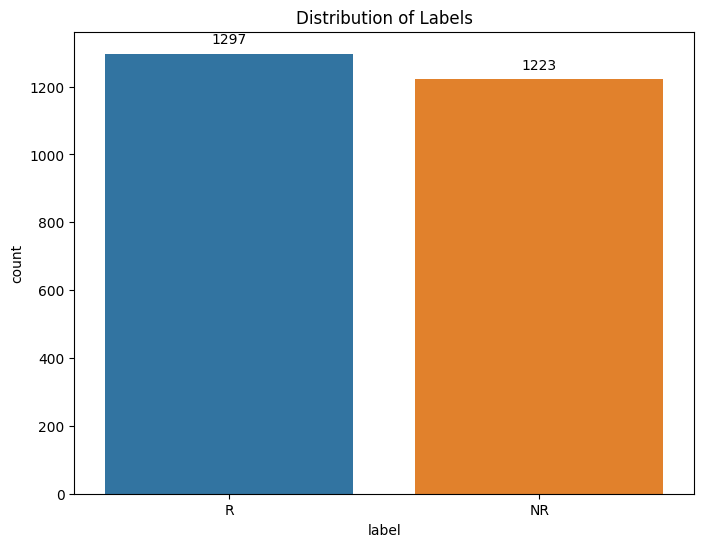

In [29]:
# Assume 'data' is your DataFrame and it has been loaded properly
# Create the countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=data)
plt.title('Distribution of Labels')

# Annotate the number of observations on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

The bar chart illustrates the distribution of labels between Residential (R) and Non-Residential (NR) areas. There are 1,297 instances labeled as Residential and 1,223 as Non-Residential, which indicates a relatively balanced distribution between the two types of land use.

**Feature Distributions by Region Type**  
Aggregating user, tweet, and entropy features into sums and then visualizing the distributions of these aggregated features for different labels 

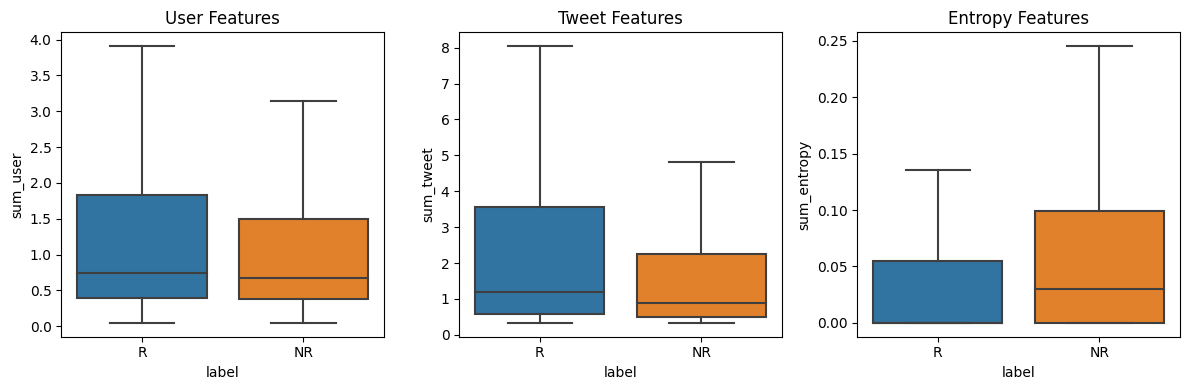

In [30]:
# Sum the 'user' features
data['sum_user'] = data.filter(regex='^user_').sum(axis=1)

# Sum the 'tweet' features
data['sum_tweet'] = data.filter(regex='^tw_').sum(axis=1)

# Sum the 'entropy' features
data['sum_entropy'] = data.filter(regex='^entropy_').sum(axis=1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.boxplot(x='label', y='sum_user', data=data, showfliers=False)
plt.title('User Features')
plt.subplot(1, 3, 2)
sns.boxplot(x='label', y='sum_tweet', data=data,  showfliers=False)
plt.title('Tweet Features')
plt.subplot(1, 3, 3)
sns.boxplot(x='label', y='sum_entropy', data=data,  showfliers=False)
plt.title('Entropy Features')
plt.tight_layout()


- **User Features**: There appears to be a moderate distribution of values for both R and NR, with the median value for NR slightly higher than for R, indicating more users in non-residential areas.

- **Tweet Features**: The distribution for tweet features shows a higher median and wider interquartile range for NR, which may suggest greater variability and higher tweet activity in non-residential areas.

- **Entropy Features**: The entropy box plot shows a notably higher median for NR, as well as a greater range of values, which could be interpreted as a higher level of disorder or diversity in tweet patterns in non-residential areas.

### 3.1.2.1 Hourly data exploration   
the comparison of tweet features, user features, and entropy features over time for both residential and non-residential areas. the sum of these features is calculated for both R and NR labels to examine the aggregate behavior patterns within these two different types of regions.



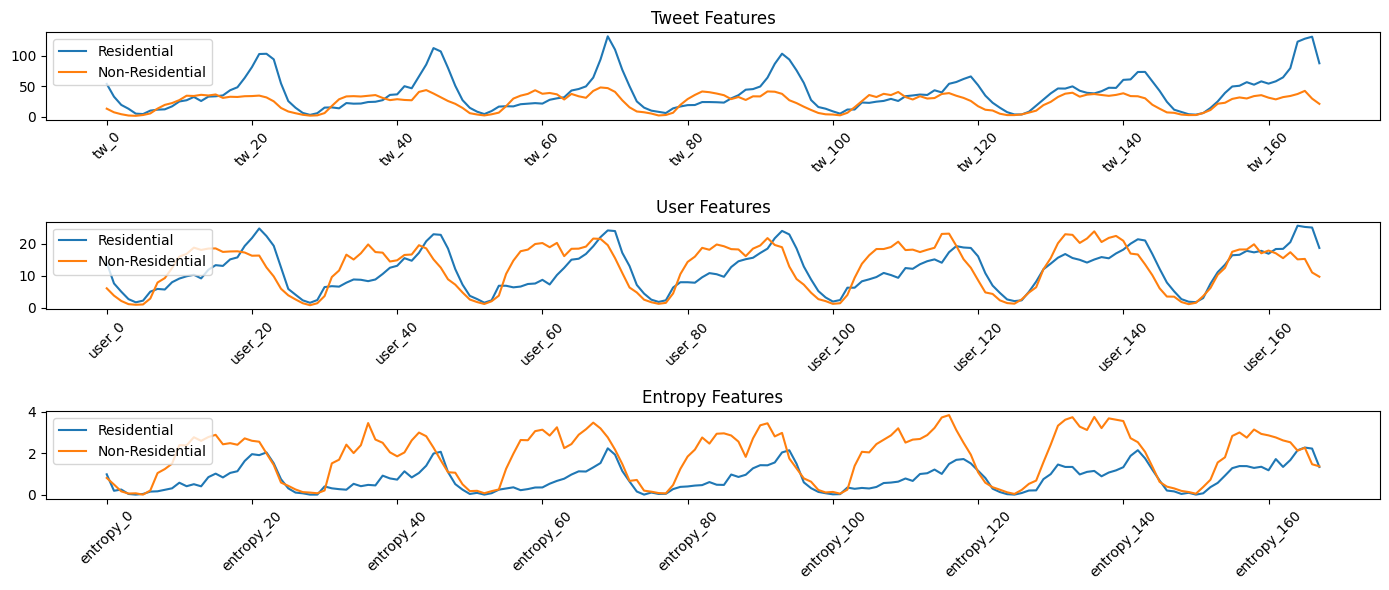

In [31]:
# First, separate the features into categories based on their prefixes
tweet_features = data.filter(regex='^tw_')
user_features = data.filter(regex='^user_')
entropy_features = data.filter(regex='^entropy_')
labels = data['label']

# Group by the label to calculate the sum for R and NR areas
sum_tweets_R = tweet_features[labels == 'R'].sum()
sum_tweets_NR = tweet_features[labels == 'NR'].sum()
sum_users_R = user_features[labels == 'R'].sum()
sum_users_NR = user_features[labels == 'NR'].sum()
sum_entropy_R = entropy_features[labels == 'R'].sum()
sum_entropy_NR = entropy_features[labels == 'NR'].sum()

# Now create line plots for each category
plt.figure(figsize=(14, 6))
plt.subplot(3, 1, 1)
plt.plot(sum_tweets_R.index, sum_tweets_R.values, label='Residential')
plt.plot(sum_tweets_NR.index, sum_tweets_NR.values, label='Non-Residential')
plt.title('Tweet Features')
plt.legend()
plt.xticks(ticks=range(0, len(tweet_features.columns), 20), 
           labels=tweet_features.columns[::20], 
           rotation=45)

plt.subplot(3, 1, 2)
plt.plot(sum_users_R.index, sum_users_R.values, label='Residential')
plt.plot(sum_users_NR.index, sum_users_NR.values, label='Non-Residential')
plt.title('User Features')
plt.legend()
plt.xticks(ticks=range(0, len(user_features.columns), 20), 
           labels=user_features.columns[::20], 
           rotation=45)

plt.subplot(3, 1, 3)
plt.plot(sum_entropy_R.index, sum_entropy_R.values, label='Residential')
plt.plot(sum_entropy_NR.index, sum_entropy_NR.values, label='Non-Residential')
plt.title('Entropy Features')
plt.legend()
plt.xticks(ticks=range(0, len(entropy_features.columns), 20), 
           labels=entropy_features.columns[::20], 
           rotation=45)
plt.tight_layout()
plt.show()


- **Residential (R) Areas**:
    - Peak tweet volume around 8-9 PM, indicating highest activity during these hours.
    -Corresponding peaks in user count and entropy suggest diverse interactions during this time.
- **Non-Residential (NR) Areas**:
    - Lower overall tweet volume compared to R, lacking sharp peaks.
    - Consistently higher user count during daytime hours, suggesting sustained activity in these areas.
    - User count peaks for NR precede those for R, and entropy values are consistently higher throughout the day.  

***Insights:***
1. The pronounced evening peak in R areas might reflect residential downtime.
1. The sustained daytime user activity in NR areas could indicate commercial or business use.
1. The consistently higher entropy in NR areas could reflect a broader variety of topics or more diverse user interactions.-
1. The time-stamped patterns can be indicative of lifestyle and activity differences between residential and non-residential areas.

### 3.1.2.2 Daily data exploration   
Group every 24h (columns) of each feature type and sum them

***When dealing with temporal and high-dimensional data, time aggregation techniques like daily and weekly summing are powerful tools in preparing data for clustering analysis***

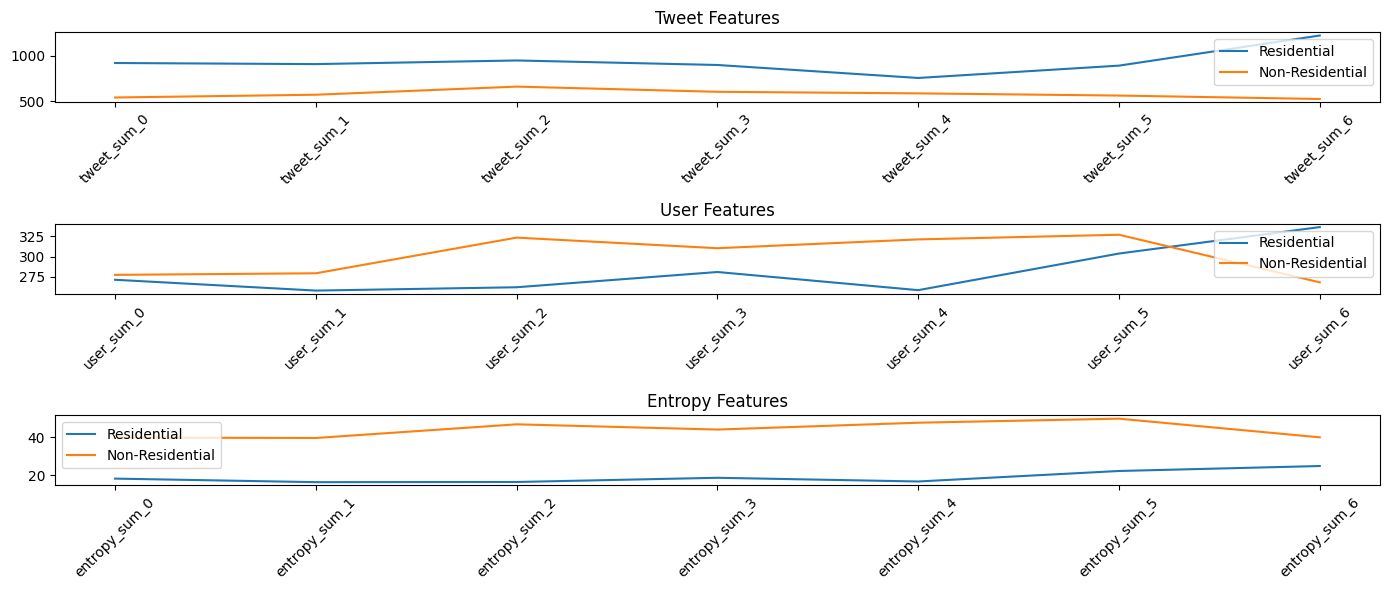

In [32]:
tweet_sums_daily = tweet_features.groupby(np.arange(len(tweet_features.columns)) // 24, axis=1).sum()
user_sums_daily = user_features.groupby(np.arange(len(user_features.columns)) // 24, axis=1).sum()
entropy_sums_daily = entropy_features.groupby(np.arange(len(entropy_features.columns)) // 24, axis=1).sum()

# Rename columns to reflect their new grouped nature
tweet_sums_daily.columns = [f'tweet_sum_{i}' for i in range(tweet_sums_daily.shape[1])]
user_sums_daily.columns = [f'user_sum_{i}' for i in range(user_sums_daily.shape[1])]
entropy_sums_daily.columns = [f'entropy_sum_{i}' for i in range(entropy_sums_daily.shape[1])]

labels = data['label']

# Group by the label to calculate the sum for R and NR areas
sum_tweets_daily_R = tweet_sums_daily[labels == 'R'].sum()
sum_tweets_daily_NR = tweet_sums_daily[labels == 'NR'].sum()
sum_users_daily_R = user_sums_daily[labels == 'R'].sum()
sum_users_daily_NR = user_sums_daily[labels == 'NR'].sum()
sum_entropy_daily_R = entropy_sums_daily[labels == 'R'].sum()
sum_entropy_daily_NR = entropy_sums_daily[labels == 'NR'].sum()

# Now create line plots for each category
plt.figure(figsize=(14, 6))
plt.subplot(3, 1, 1)
plt.plot(sum_tweets_daily_R.index, sum_tweets_daily_R.values, label='Residential')
plt.plot(sum_tweets_daily_NR.index, sum_tweets_daily_NR.values, label='Non-Residential')
plt.title('Tweet Features')
plt.legend()
plt.xticks(ticks=range(0, len(tweet_sums_daily.columns)), 
           labels=tweet_sums_daily.columns, 
           rotation=45)

plt.subplot(3, 1, 2)
plt.plot(sum_users_daily_R.index, sum_users_daily_R.values, label='Residential')
plt.plot(sum_users_daily_NR.index, sum_users_daily_NR.values, label='Non-Residential')
plt.title('User Features')
plt.legend()
plt.xticks(ticks=range(0, len(user_sums_daily.columns)), 
           labels=user_sums_daily.columns, 
           rotation=45)

plt.subplot(3, 1, 3)
plt.plot(sum_entropy_daily_R.index, sum_entropy_daily_R.values, label='Residential')
plt.plot(sum_entropy_daily_NR.index, sum_entropy_daily_NR.values, label='Non-Residential')
plt.title('Entropy Features')
plt.legend()
plt.xticks(ticks=range(0, len(entropy_sums_daily.columns)), 
           labels=entropy_sums_daily.columns, 
           rotation=45)
plt.tight_layout()
plt.show()


**Tweet Features:** Residential tweet volume appears consistently higher, with non-residential tweet volume trailing but following a similar pattern across the week.     

**User Features:** User counts in residential areas start lower but surpass non-residential counts mid-week, suggesting a possible increase in user activity in residential areas as the week progresses.      

**Entropy Features:** Entropy in non-residential areas is consistently higher across the week, implying a greater diversity of tweets, which remains relatively unchanged throughout the week.      

***Compare with hourly data***
This contrasts with daily data where you might see more variability day-to-day. Daily aggregation smooths out such fluctuations, potentially highlighting more stable, long-term patterns in user behavior and tweet characteristics.

## **3.1.3 Fourier Transform**   
The intention of utilizing Fourier transform is to identify and leverage **time series characteristics** that could differentiate between Residential (R) and Non-Residential (NR) regions, based on the clear temporal trends observed in the **hourly data line plots**.

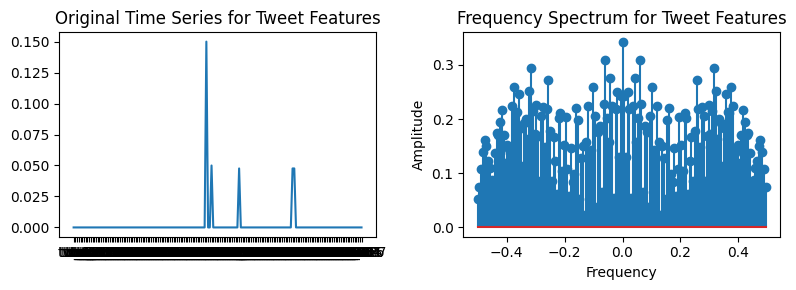

In [33]:
tweet_record = tweet_features.iloc[0, :]  # First row of the data

# Perform Fourier Transform
fft_values = np.fft.fft(tweet_record)
frequencies = np.fft.fftfreq(len(tweet_record))
plt.figure(figsize=(8, 3))

# Time series plot
plt.subplot(1, 2, 1)
plt.plot(tweet_record.index, tweet_record.values)
plt.title('Original Time Series for Tweet Features')

# Frequency spectrum plot
plt.subplot(1, 2, 2)
plt.stem(frequencies, np.abs(fft_values))
plt.title('Frequency Spectrum for Tweet Features')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


with a time series largely comprised of zeroes, the Fourier transform reveals that there is a low signal-to-noise ratio, with the "signal" being the non-zero activity periods and the "noise" being the zero-value periods. This suggests that the tweet activity does not have regular, predictable patterns, or at least none that can be easily detected with a Fourier transform due to the sparse nature of the events.

# ***3.2 Clustering***  
- Original data (2520, 504)
- PCA (90%) (2520, 31)
- Hourly data (2520, 21)
- Weekly data (2520, 3)


## **3.2.1 Exercise with k-means**

In [34]:
import os
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

from scipy.stats import mode
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import numpy as np
import random

*Original data for Kmeans clustering*

In [35]:
# Prepare the feature set for clustering, excluding non-numeric columns if necessary
original_data = data.drop(columns=['id', 'parcel_name', 'label', 'sum_user', 'sum_tweet', 'sum_entropy'])
print("check the original_data",original_data.shape)

check the original_data (2520, 504)


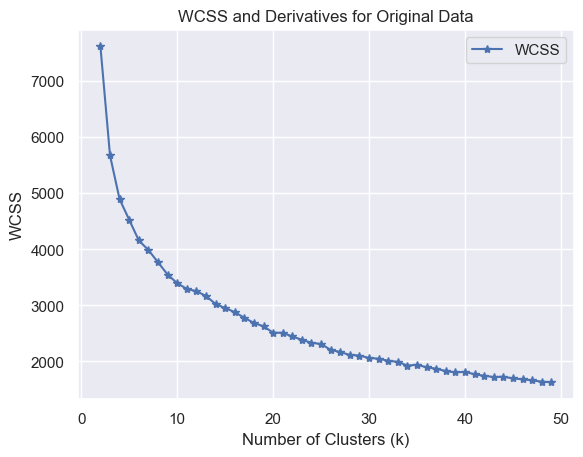

In [41]:
# List of k values
k_values = range(2, 50)

# List of withinss values
withinss_values = []

# Calculate withinss for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(original_data)
    withinss_values.append(kmeans.inertia_)

# Assume withinss_values are the previously calculated WCSS data
withinss_values = np.array(withinss_values)  # Make sure this is a NumPy array

# Plot the original data and the derivatives
plt.plot(k_values, withinss_values, '*-', label='WCSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('WCSS and Derivatives for Original Data')
plt.legend()
plt.show()



The WCSS plot for the original data, which has not been subjected to any dimensionality reduction. The curve shows a gradual decrease in WCSS as the number of clusters increases. Although the curve is smooth and the elbow is not very pronounced, a tentative elbow appears to be around *k=10 to k=15*, after which the rate of decrease in WCSS slows down, indicating a potential region for the optimal number of clusters.

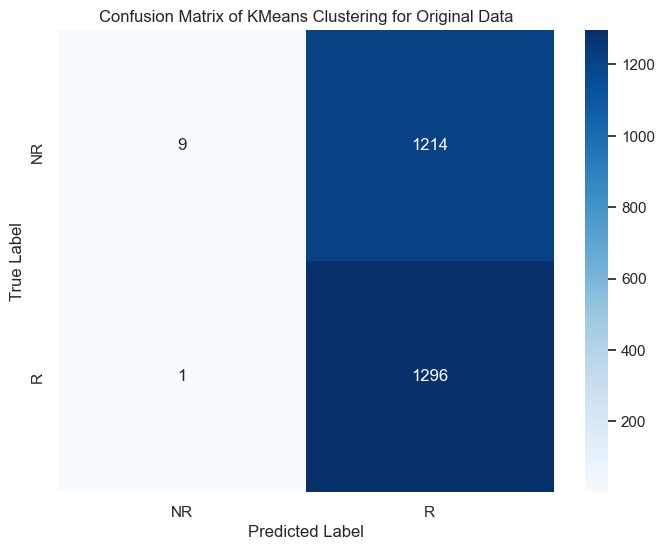

Classification Report:
               precision    recall  f1-score   support

          NR       0.90      0.01      0.01      1223
           R       0.52      1.00      0.68      1297

    accuracy                           0.52      2520
   macro avg       0.71      0.50      0.35      2520
weighted avg       0.70      0.52      0.36      2520



In [70]:
# Fit the KMeans model
best_original_k = 12
kmeans = KMeans(n_clusters=best_original_k, random_state=42)
kmeans.fit(original_data)

# Predict the cluster labels
predicted_labels = kmeans.predict(original_data)

# Map the predicted cluster labels to the true labels
label_mapping = {}
for cluster_id in set(predicted_labels):
    # Indices of rows in this cluster
    cluster_indices = predicted_labels == cluster_id
    # True labels of rows in this cluster
    real_labels = data.loc[cluster_indices, 'label']
    # Most common true label in this cluster
    most_common_label = mode(real_labels).mode[0]
    # Map cluster ID to the most common true label
    label_mapping[cluster_id] = most_common_label

# Apply the mapping
mapped_predicted_labels = pd.Series(predicted_labels).map(label_mapping)

# Compute the confusion matrix
conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KMeans Clustering for Original Data')
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)


## **3.2.2. Exercise with dimension reduction**

#### **3.2.2.1. PCA**
Apply PCA to reduce the dimensionality of the data while retaining 90% variances.   
*Original shape: (2520, 504), PCA shape: (2520, 31) The dimension decreased from 504 to 31*

Original shape: (2520, 504), PCA shape: (2520, 31)


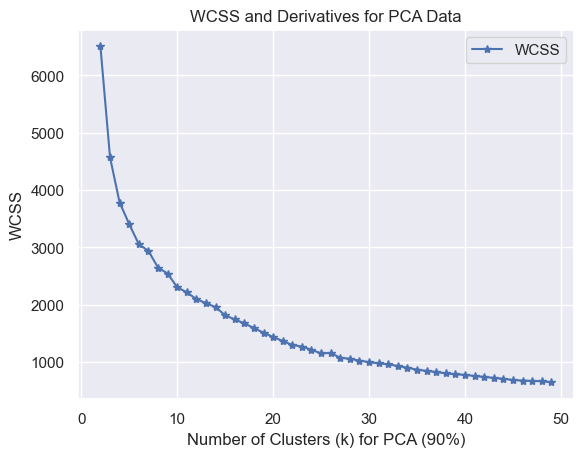

In [71]:
from sklearn.decomposition import PCA

# pca = PCA(n_components= round((original_data.shape[1])*0.9), random_state=42)
pca = PCA(n_components= 0.9, random_state=42)
X_pca = pca.fit_transform(original_data)
print(f"Original shape: {original_data.shape}, PCA shape: {X_pca.shape}")

# Check how many components PCA chose
num_components = pca.n_components_
# List of k values
k_values = range(2, 50)

# List of withinss values
withinss_values = []

# Calculate withinss for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k)

    kmeans.fit(X_pca)
    withinss_values.append(kmeans.inertia_)

# Assume withinss_values are the previously calculated WCSS data
withinss_values = np.array(withinss_values)  # Make sure this is a NumPy array

# Calculate the first derivative
first_derivative = np.diff(withinss_values) / np.diff(k_values)

# Calculate the second derivative
second_derivative = np.diff(first_derivative) / np.diff(k_values[:-1])  # Note that the length of k_values is reduced by one

# Plot the original data and the derivatives

plt.plot(k_values, withinss_values, '*-', label='WCSS')
plt.xlabel('Number of Clusters (k) for PCA (90%)')
plt.ylabel('WCSS')
plt.title('WCSS and Derivatives for PCA Data')
plt.legend()
plt.show()

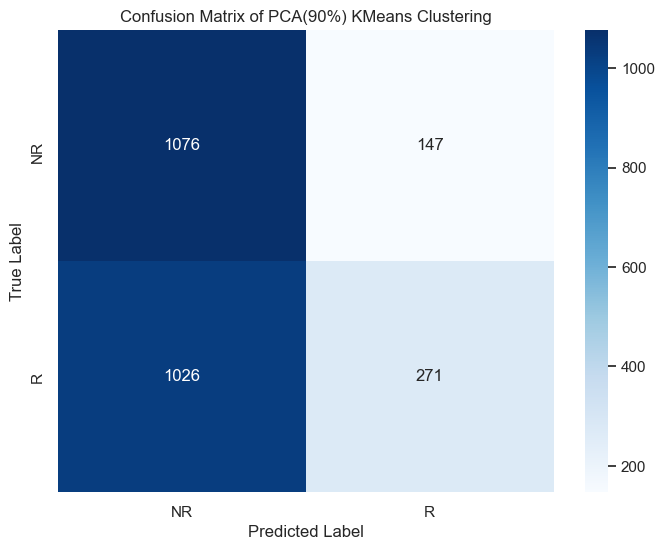

Classification Report:
               precision    recall  f1-score   support

          NR       0.51      0.88      0.65      1223
           R       0.65      0.21      0.32      1297

    accuracy                           0.53      2520
   macro avg       0.58      0.54      0.48      2520
weighted avg       0.58      0.53      0.48      2520



In [53]:
best_pca_k = 18
# Now, apply k-means clustering on the PCA-reduced data
kmeans_pca = KMeans(n_clusters= best_pca_k, random_state=42)
kmeans_pca.fit(X_pca)
predicted_labels_pca = kmeans_pca.predict(X_pca)

# Create the mapping from predicted cluster labels to actual labels
label_mapping_pca = {}
for cluster_id in np.unique(predicted_labels_pca):
    cluster_indices = (predicted_labels_pca == cluster_id)
    if cluster_indices.any():  # Ensure there's at least one point in the cluster
        real_labels = data.loc[cluster_indices, 'label']
        if not real_labels.empty:
            most_common_label = mode(real_labels).mode[0]
            label_mapping_pca[cluster_id] = most_common_label
        else:
            label_mapping_pca[cluster_id] = 'Unknown'
            print(f"No real labels in cluster {cluster_id}")

# Handle any unexpected cluster labels by defaulting to 'Unknown'
mapped_predicted_labels = [label_mapping_pca.get(label, 'Unknown') for label in predicted_labels_pca]

conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of PCA(90%) KMeans Clustering')
plt.show()

print("Classification Report:\n", class_report)

**Before PCA**: with 12 clusters, the model had a very high precision for NR at 0.90 but a very low recall of 0.01, indicating it rarely identified NR instances correctly. Conversely, the precision for R was lower (0.52), but recall was perfect (1.00), meaning it captured all R instances but also included many false positives.   

**After PCA**: with 18 clusters selected, the clustering performance appears more balanced as per the confusion matrix. While precision for the 'Non-Residential' (NR) class is at 0.51 and recall is high at 0.88, indicating most NR instances are correctly identified but with a moderate false positive rate, the 'Residential' (R) class shows a lower precision of 0.65 and a significantly lower recall of 0.21, suggesting that the model frequently misses R instances.   

**Comparision:** PCA seems to have improved the balance between precision and recall for NR, reducing false positives while maintaining a good true positive rate. For R, post-PCA, there's a trade-off: a decrease in false positives but an increase in false negatives. The overall accuracy remains roughly the same. The choice of using PCA seems to have provided a more nuanced clustering that better differentiates NR from R compared to the original data clustering, which was heavily biased towards the R class. However, the recall for R has dropped, indicating that the model is now missing more instances of the R class than before. This suggests that while PCA helped in distinguishing NR instances to some extent, it also obscured some of the R instances, leading to a more evenly distributed but less sensitive model for the R class.

#### **3.2.2.2 Time Aggregation** [Daily/ Weekly Data]
A large number of features can make the model harder to interpret and understand.  
So in the nest step, I will decrease the dimensions manually by aggregating the features to daily and weekly data, and sum the data over the respective periods.

In [73]:
# Concatenate the DataFrames into one DataFrame with daily sums for tweets, users, and entropy.
daily_data = pd.concat([tweet_sums_daily, user_sums_daily, entropy_sums_daily], axis=1)
# Weekly sums for tweets, users, and entropy
weekly_data = data[['sum_user', 'sum_tweet', 'sum_entropy']]

##### *Daily*  k=10

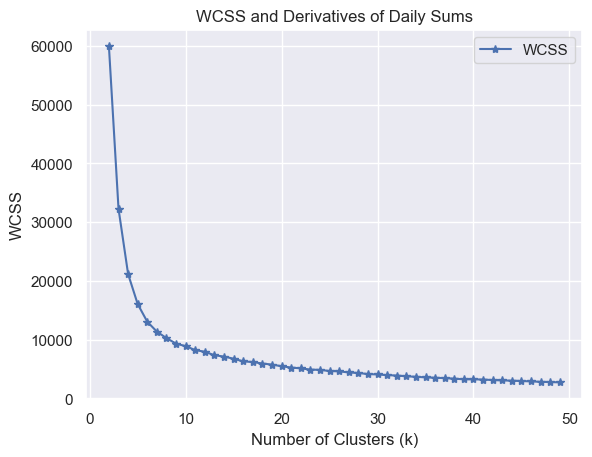

In [74]:
# List of k values
k_values = range(2, 50)

# List of withinss values
withinss_values = []

# Calculate withinss for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k)

    kmeans.fit(daily_data)
    withinss_values.append(kmeans.inertia_)

# Assume withinss_values are the previously calculated WCSS data
withinss_values = np.array(withinss_values)  # Make sure this is a NumPy array

# Calculate the first derivative
first_derivative = np.diff(withinss_values) / np.diff(k_values)

# Calculate the second derivative
second_derivative = np.diff(first_derivative) / np.diff(k_values[:-1])  # Note that the length of k_values is reduced by one

# Plot the original data and the derivatives
plt.plot(k_values, withinss_values, '*-', label='WCSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('WCSS and Derivatives of Daily Sums')
plt.legend()
plt.show()



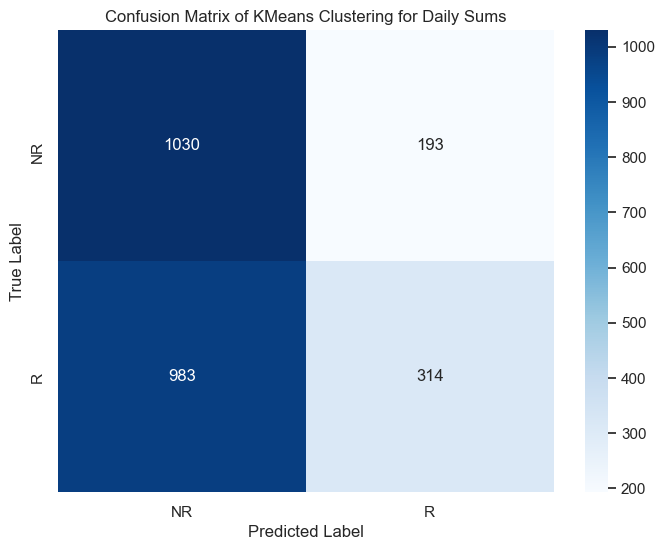

Classification Report:
               precision    recall  f1-score   support

          NR       0.51      0.84      0.64      1223
           R       0.62      0.24      0.35      1297

    accuracy                           0.53      2520
   macro avg       0.57      0.54      0.49      2520
weighted avg       0.57      0.53      0.49      2520



In [80]:
# Fit the KMeans model
best_daily_k = 10
kmeans = KMeans(n_clusters=best_daily_k, random_state=42)
kmeans.fit(daily_data)

# Predict the cluster labels
predicted_labels = kmeans.predict(daily_data)

# Map the predicted cluster labels to the true labels
label_mapping = {}
for cluster_id in set(predicted_labels):
    # Indices of rows in this cluster
    cluster_indices = predicted_labels == cluster_id
    # True labels of rows in this cluster
    real_labels = data.loc[cluster_indices, 'label']
    # Most common true label in this cluster
    most_common_label = mode(real_labels).mode[0]
    # Map cluster ID to the most common true label
    label_mapping[cluster_id] = most_common_label

# Apply the mapping
mapped_predicted_labels = pd.Series(predicted_labels).map(label_mapping)

# Compute the confusion matrix
conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KMeans Clustering for Daily Sums')
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)


##### *Weekly*  k=10
Only using the sum_user, sum_tweet, and sum_entropy


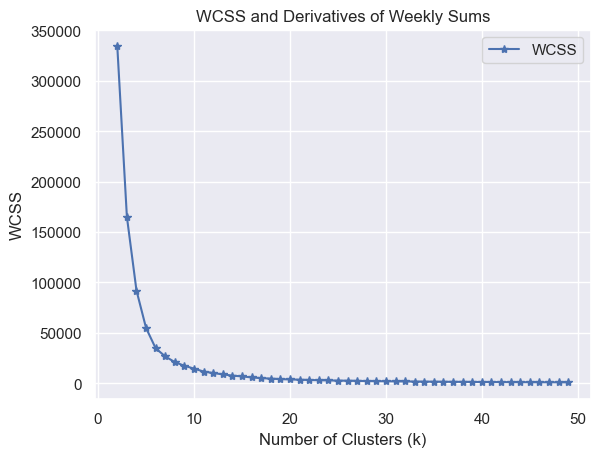

In [76]:
# List of k values
k_values = range(2, 50)

# List of withinss values
withinss_values = []
# Calculate withinss for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k)

    kmeans.fit(weekly_data)
    withinss_values.append(kmeans.inertia_)

# Assume withinss_values are the previously calculated WCSS data
withinss_values = np.array(withinss_values)  # Make sure this is a NumPy array

# Calculate the first derivative
first_derivative = np.diff(withinss_values) / np.diff(k_values)

# Calculate the second derivative
second_derivative = np.diff(first_derivative) / np.diff(k_values[:-1])  # Note that the length of k_values is reduced by one

# Plot the original data and the derivatives
plt.plot(k_values, withinss_values, '*-', label='WCSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('WCSS and Derivatives of Weekly Sums')
plt.legend()
plt.show()

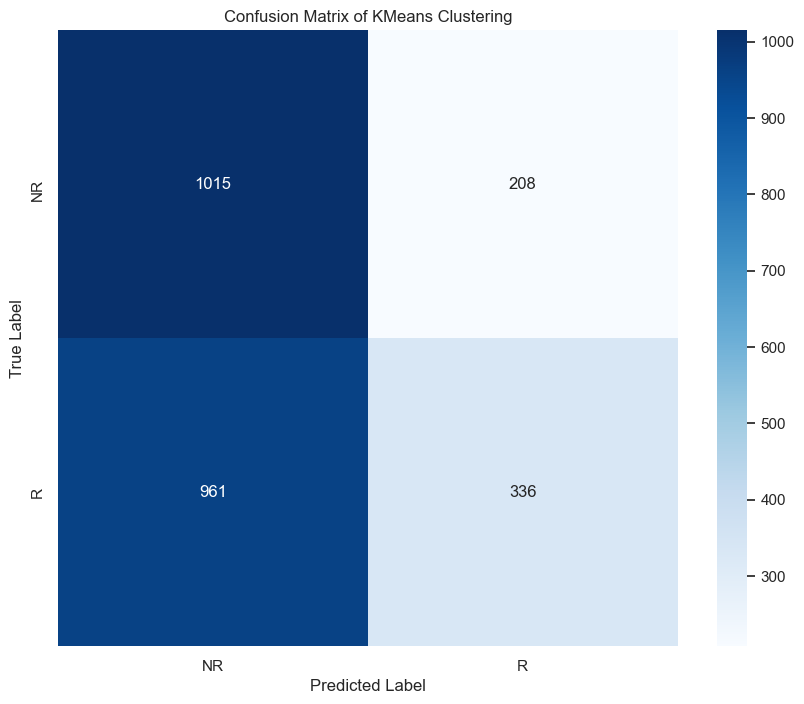

Classification Report:
               precision    recall  f1-score   support

          NR       0.51      0.83      0.63      1223
           R       0.62      0.26      0.37      1297

    accuracy                           0.54      2520
   macro avg       0.57      0.54      0.50      2520
weighted avg       0.57      0.54      0.50      2520



In [79]:
# Assuming we have the true labels in the 'label' column
true_labels = data['label']
best_weekly_k = 10
# Create an instance of KMeans with k=10
kmeans = KMeans(n_clusters= best_weekly_k)
# Fit the KMeans model to the standardized data
kmeans.fit(weekly_data)

# Predict the cluster labels for the data
predicted_labels = kmeans.predict(weekly_data)

# Map predicted cluster labels to true labels using the known labels in the dataset
label_mapping = {}
for cluster_id in set(predicted_labels):
    # Find the indices of rows in this cluster
    cluster_indices = (predicted_labels == cluster_id)
    # Get the true labels of those rows
    real_labels = data.loc[cluster_indices, 'label']
    # Find the most common true label in this cluster
    most_common_label = mode(real_labels).mode[0]
    # Map the cluster_id to the most common true label
    label_mapping[cluster_id] = most_common_label

# Now we have a mapping from cluster ID to the true label
# Apply this mapping to get the true labels for the entire dataset
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]
result = pd.Series(predicted_labels).map(label_mapping)
conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KMeans Clustering')
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)

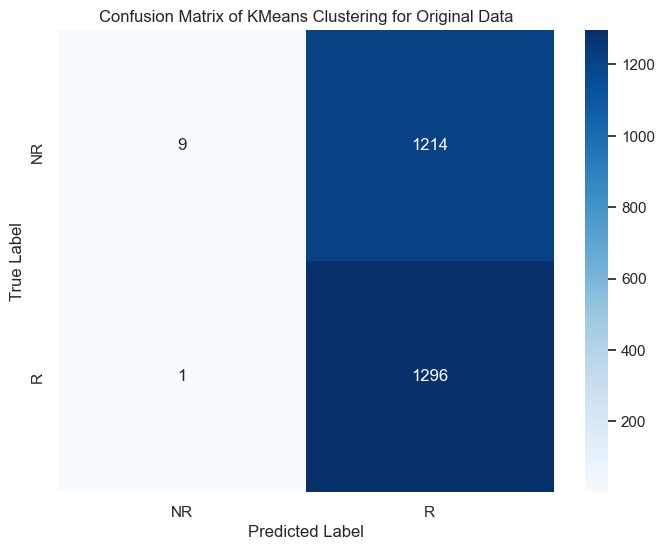

Classification Report:
               precision    recall  f1-score   support

          NR       0.90      0.01      0.01      1223
           R       0.52      1.00      0.68      1297

    accuracy                           0.52      2520
   macro avg       0.71      0.50      0.35      2520
weighted avg       0.70      0.52      0.36      2520



In [ ]:
# Fit the KMeans model
best_original_k = 12
kmeans = KMeans(n_clusters=best_original_k, random_state=42)
kmeans.fit(original_data)

# Predict the cluster labels
predicted_labels = kmeans.predict(original_data)

# Map the predicted cluster labels to the true labels
label_mapping = {}
for cluster_id in set(predicted_labels):
    # Indices of rows in this cluster
    cluster_indices = predicted_labels == cluster_id
    # True labels of rows in this cluster
    real_labels = data.loc[cluster_indices, 'label']
    # Most common true label in this cluster
    most_common_label = mode(real_labels).mode[0]
    # Map cluster ID to the most common true label
    label_mapping[cluster_id] = most_common_label

# Apply the mapping
mapped_predicted_labels = pd.Series(predicted_labels).map(label_mapping)

# Compute the confusion matrix
conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KMeans Clustering for Original Data')
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)


### ***Summary***  
**Comparison with PCA Results:**

- Both daily and weekly sum data have higher recall rates for NR compared to before PCA, suggesting better identification of the NR class.
- Precision for R is higher in the daily and weekly sum data compared to after PCA, indicating fewer instances of R are mislabeled.
- The overall accuracy for both daily and weekly sums is higher than before PCA and equivalent to after PCA, indicating a more balanced and slightly better model performance.
- F1-scores for NR in daily and weekly data are close to after PCA, but for R, they are significantly better, suggesting improvements in how R instances are classified compared to the PCA models. 

***My Guess as to the Resaons for the Observed Trends!:***
- *The aggregation into daily and weekly sums may have helped to **emphasize patterns** in the data that are relevant for classification, potentially **reducing noise** that might be present on an hourly scale.*  
- *The use of sums rather than raw hourly data could highlight trends and behaviors more clearly, improving the distinction between NR and R.*

## **3.2.3. Comparison of K-means and Agglomerative Hierarchical Clustering**

In [20]:
from sklearn.cluster import AgglomerativeClustering

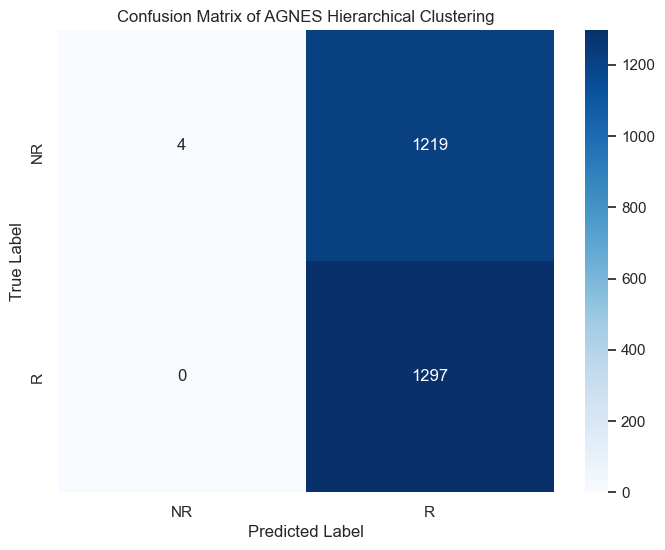

Classification Report:
               precision    recall  f1-score   support

          NR       1.00      0.00      0.01      1223
           R       0.52      1.00      0.68      1297

    accuracy                           0.52      2520
   macro avg       0.76      0.50      0.34      2520
weighted avg       0.75      0.52      0.35      2520



In [84]:
# Apply the AGNES hierarchical clustering algorithm
agg_clustering = AgglomerativeClustering(
    n_clusters = best_original_k,  # This should be set to the best k value found in Section 3.2.1
    affinity='euclidean',
    linkage='single'  # Try 'ward', 'complete', 'average', 'single', etc.
)
predicted_labels = agg_clustering.fit_predict(original_data)

# Map the predicted cluster labels to the true labels
label_mapping = {}
for cluster_id in range(best_original_k):
    # Find the indices of points in this cluster
    indices = (predicted_labels == cluster_id)
    # Get the actual labels of these points
    actual_labels = true_labels[indices]
    # Determine the most common label
    most_common_label = mode(actual_labels).mode[0]
    label_mapping[cluster_id] = most_common_label

# Apply the mapping
mapped_predicted_labels = pd.Series(predicted_labels).map(label_mapping)

# Compute the confusion matrix
conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of AGNES Hierarchical Clustering')
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)


# ***3.3 Classification***

*Use the raw feature set and reserve 20% of all records as the test set and use the rest as 
the training set.*

In [88]:
from sklearn.model_selection import train_test_split
# Split data into features and target
X = original_data  # This assumes 'label' is the name of your target column
y = data['label']
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **3.3.1. K-Fold Cross-validation**

In [89]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score,mean_squared_error
from sklearn.pipeline import Pipeline
import time
from sklearn.preprocessing import LabelEncoder

In [90]:
# Feature scaling (important for kNN and ANN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Setup K-Fold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store best estimators
best_estimators = {}

#### The parameters of these models

In [92]:
# k-Nearest Neighbors
knn_params = {
    'n_neighbors': [3, 5, 7], # Number of neighbors
    'weights': ['uniform', 'distance'], # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree'] # Algorithm used to compute the nearest neighbors
}
knn_model = KNeighborsClassifier()

# Decision Tree
dt_params = {
    'max_depth': [None, 10, 20], # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'criterion': ['gini', 'entropy'], # Function to measure the quality of a split
    'splitter': ['best', 'random'] # Strategy used to choose the split at each node
}
dt_model = DecisionTreeClassifier(random_state=42)

# Random Forest
rf_params = {
    'n_estimators': [50, 100, 200], # Number of trees
    'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at each split
    'max_depth': [None, 10, 20], # Maximum depth of the tree
    'min_samples_split': [2, 5, 10] # Minimum number of samples required to split a node
}
rf_model = RandomForestClassifier(random_state=42)

# Artificial Neural Network
ann_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)], # Single hidden layer with 50 neurons
    'learning_rate_init': [0.01, 0.001, 0.0001], # Initial learning rate
    'solver': ['adam', 'sgd'] # Optimization algorithm
}
ann_model = MLPClassifier(max_iter=500, random_state=42)

# Define models and parameters
models_params = {
    'KNN': (knn_model, knn_params),
    'DT': (dt_model, dt_params),
    'RF': (rf_model, rf_params),
    'ANN': (ann_model, ann_params)
}

### KNN

In [96]:
name = 'KNN'
print(f"Processing {name}...")
clf = GridSearchCV(estimator=knn_model, param_grid=knn_params, cv=kfold, scoring=['accuracy','f1'], n_jobs=-1)
clf.fit(X_train_scaled, y_train)
best_estimators[name] = clf.best_estimator_
print(f"Best parameters for {name}: {clf.best_params_}")
print(f"Best cross-validation accuracy: {clf.best_score_:.2f}")
# Check for overfitting
train_score = accuracy_score(y_train, clf.predict(X_train_scaled))
test_score = accuracy_score(y_test, clf.predict(X_test_scaled))
print(f"Training score: {train_score:.2f}, Test score: {test_score:.2f}")
print('----------------------------------------------------------------------')

Processing KNN...


ValueError: For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit an estimator with the best parameter setting on the whole data and make the best_* attributes available for that metric. If this is not needed, refit should be set to False explicitly. True was passed.

In [26]:

# Process each model
for name, (model, params) in models_params.items():
    print(f"Processing {name}...")
    starttime = time.time()
    clf = GridSearchCV(estimator=model, param_grid=params, cv=kfold, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train_scaled, y_train)
    best_estimators[name] = clf.best_estimator_
    print(f"Best parameters for {name}: {clf.best_params_}")
    print(f"Best cross-validation accuracy: {clf.best_score_:.2f}")
    # Check for overfitting
    train_score = accuracy_score(y_train, clf.predict(X_train_scaled))
    test_score = accuracy_score(y_test, clf.predict(X_test_scaled))
    endtime = time.time()
    process_duration = endtime - starttime
    print(f"Training score: {train_score:.2f}, Test score: {test_score:.2f}")
    print(f"Process duration: {process_duration:.2f} seconds")
    print('----------------------------------------------------------------------')

Processing KNN...
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
Best cross-validation accuracy: 0.65
Training score: 0.77, Test score: 0.64
Process duration: 11.51 seconds
----------------------------------------------------------------------
Processing DT...
Best parameters for DT: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation accuracy: 0.66
Training score: 0.78, Test score: 0.60
Process duration: 4.37 seconds
----------------------------------------------------------------------
Processing RF...
Best parameters for RF: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation accuracy: 0.74
Training score: 0.93, Test score: 0.71
Process duration: 41.86 seconds
----------------------------------------------------------------------
Processing ANN...
Best parameters for ANN: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0001, 'sol

## **3.3.2. Apply to all Records**

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

### **3.3.2.1. KNN**

              precision    recall  f1-score   support

          NR       0.65      0.57      0.61       245
           R       0.64      0.71      0.67       259

    accuracy                           0.64       504
   macro avg       0.65      0.64      0.64       504
weighted avg       0.65      0.64      0.64       504



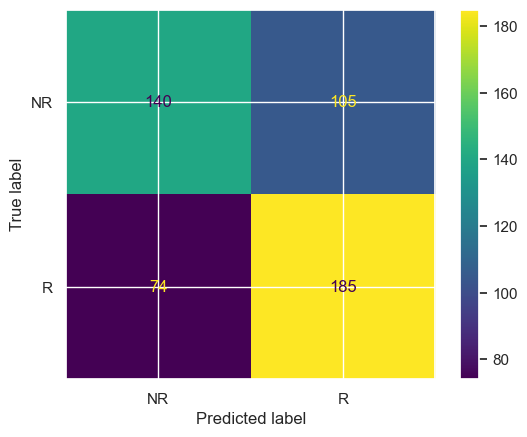

In [30]:
# Set up the KNN classifier
knn_cls = KNeighborsClassifier(algorithm='auto', n_neighbors= 7, weights= 'uniform')
knn_cls.fit(X_train_scaled, y_train)
knn_cls.score(X_test_scaled, y_test)
# make prediction given new unlabeled data (test set)
y_pred_knn = knn_cls.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_knn, labels=knn_cls.classes_)
# visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_cls.classes_)
disp.plot()
print(classification_report(y_test, y_pred_knn, target_names=np.unique(y_test)))

### **3.3.2.2. Decision Tree**

              precision    recall  f1-score   support

          NR       0.57      0.68      0.62       245
           R       0.63      0.53      0.57       259

    accuracy                           0.60       504
   macro avg       0.60      0.60      0.60       504
weighted avg       0.60      0.60      0.60       504



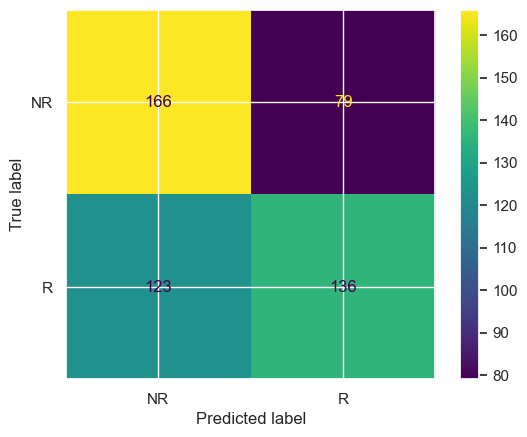

In [33]:
dt_cls = DecisionTreeClassifier(criterion='gini', max_depth =10, min_samples_split = 2, splitter = 'best')
dt_cls.fit(X_train_scaled, y_train)

# Evaluate the classifier on the test set
y_pred_dt = dt_cls.predict(X_test_scaled)

# Compute and visualize the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=dt_cls.classes_)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt_cls.classes_)
disp_dt.plot()
# Print the classification report
print(classification_report(y_test, y_pred_dt, target_names=np.unique(y_test)))


### **3.3.2.3. Random Forest**

              precision    recall  f1-score   support

          NR       0.75      0.71      0.73       245
           R       0.74      0.78      0.76       259

    accuracy                           0.74       504
   macro avg       0.74      0.74      0.74       504
weighted avg       0.74      0.74      0.74       504



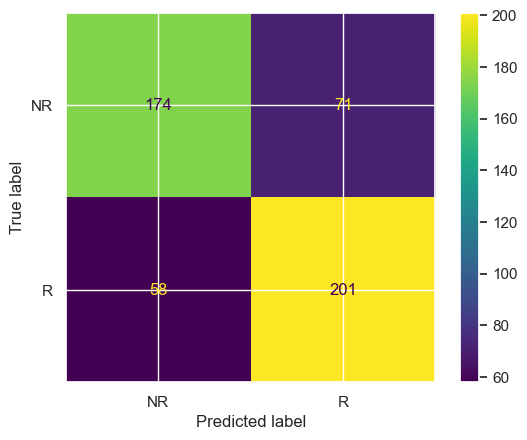

In [37]:
# Define a range of hyperparameters to test
# This example will vary the 'n_estimators', 'max_depth' and 'min_samples_split'
rf_cls = RandomForestClassifier(max_depth=20, max_features='log2', min_samples_split = 5, n_estimators = 50)

rf_cls.fit(X_train_scaled, y_train)

# Evaluate the classifier on the test set
y_pred_rf = rf_cls.predict(X_test_scaled)

# Compute and visualize the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_cls.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_cls.classes_)
disp_rf.plot()

# Print the classification report
print(classification_report(y_test, y_pred_rf, target_names=np.unique(y_test)))


### **3.3.2.4. ANN**

In [40]:
# Original labels 'R' and 'NR' which need to be encoded numerically
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

              precision    recall  f1-score   support

          NR       0.65      0.67      0.66       245
           R       0.68      0.67      0.67       259

    accuracy                           0.67       504
   macro avg       0.67      0.67      0.67       504
weighted avg       0.67      0.67      0.67       504



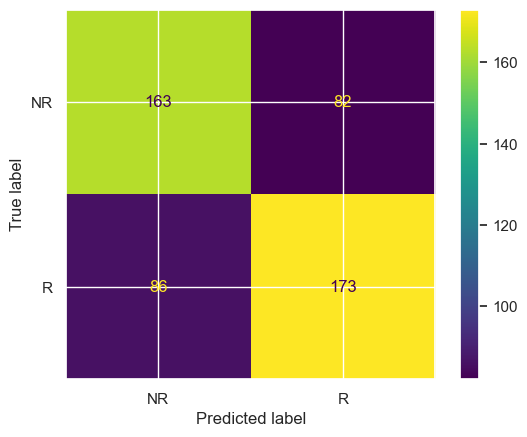

In [41]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,),  # 1 hidden layer with 100 neurons
                               activation='relu',          # ReLU activation function
                               solver='sgd',              # The solver for weight optimization.
                               random_state=42,            # Random state for reproducibility
                               learning_rate_init=0.0001)   # Initial learning rate

# Train the model
mlp_classifier.fit(X_train_scaled, y_train_encoded)

# Predict labels
y_pred_ann = mlp_classifier.predict(X_test_scaled)
y_pred_ann_label = label_encoder.inverse_transform(y_pred_ann)
# Compute and visualize the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_ann_label, labels=rf_cls.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_cls.classes_)
disp_rf.plot()

# Print the classification report
print(classification_report(y_test, y_pred_ann_label, target_names=np.unique(y_test)))

# ***4. Playground***

![image.png](playground_list.PNG)

features选择：因为前面通过测试简单的数据集1-3，发现